In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# --- Import dataset ---
# Skip the first metadata row ("Count of Births by Name...") by setting header=1
df = pd.read_csv("Baby_Names.csv", header=1)

# --- Initial data inspection ---
# Check how many missing values exist in each column
print("Missing values per column:")
print(df.isna().sum(), "\n")

# Check the data types to identify any mixed or incorrect types (object instead of int, etc.)
print("Data types before cleaning:")
print(df.dtypes, "\n")

# --- Quick sanity checks on numeric ranges ---
# View the earliest and latest year in the dataset
print("Year range:", df['Year'].min(), "to", df['Year'].max())

# View basic descriptive statistics for the 'Count' column (birth counts)
print("\nDescriptive stats for 'Count':")
print(df['Count'].describe(), "\n")

# --- Convert columns to numeric types (in case of mixed types) ---
# Coerce errors replaces non-numeric values with NaN for later cleaning
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
df['Count'] = pd.to_numeric(df['Count'], errors='coerce')

# --- Verify that conversion worked correctly ---
print("Data types after cleaning:")
print(df.dtypes, "\n")

# Display the first few rows to confirm data looks correct
print("Preview of cleaned data:")
print(df.head())


Missing values per column:
Year     0
Name     0
Sex      0
Count    0
dtype: int64 

Data types before cleaning:
Year      int64
Name     object
Sex      object
Count     int64
dtype: object 

Year range: 1880 to 2024

Descriptive stats for 'Count':
count    2.148744e+06
mean     1.730881e+02
std      1.463732e+03
min      5.000000e+00
25%      7.000000e+00
50%      1.200000e+01
75%      3.200000e+01
max      9.969300e+04
Name: Count, dtype: float64 

Data types after cleaning:
Year      int64
Name     object
Sex      object
Count     int64
dtype: object 

Preview of cleaned data:
   Year    Name Sex  Count
0  2024    Liam   M  22164
1  2024    Noah   M  20337
2  2024  Oliver   M  15343
3  2024  Olivia   F  14718
4  2024    Emma   F  13485


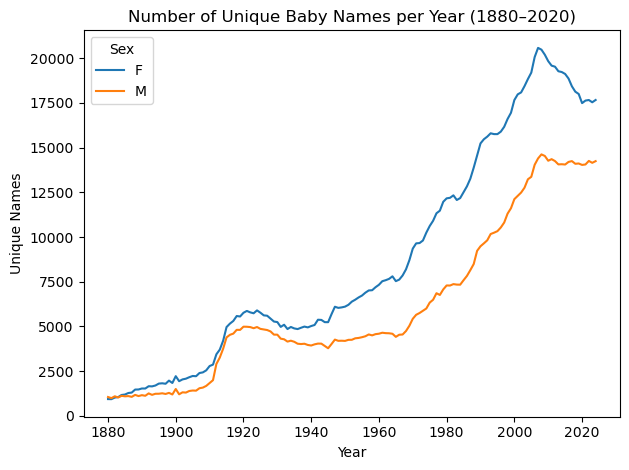

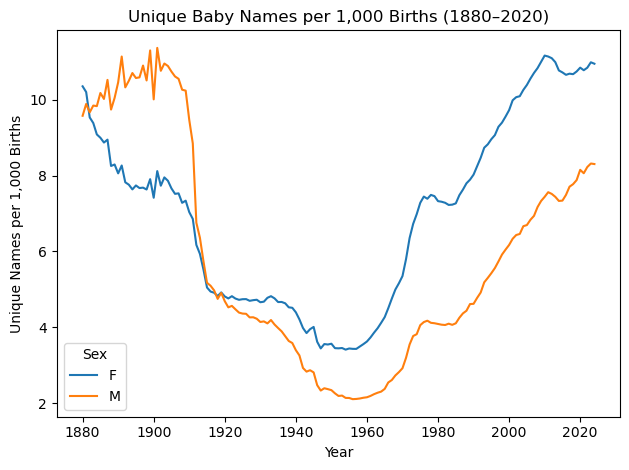

In [3]:
# Question 1: How has the diversity of baby names changed over time?
# Diversity of baby names over time
# --- Number of unique names per year by gender ---
diversity = df.groupby(['Year', 'Sex'])['Name'].nunique().reset_index()

sns.lineplot(data=diversity, x='Year', y='Name', hue='Sex')
plt.title("Number of Unique Baby Names per Year (1880–2020)")
plt.xlabel("Year")
plt.ylabel("Unique Names")
plt.legend(title="Sex")
plt.tight_layout()
plt.show()

# Unique names per capita
# --- Number of unique names per year by gender ---
diversity = df.groupby(['Year', 'Sex'])['Name'].nunique().reset_index(name='Unique_Names')

# --- Total number of births per year by gender ---
total_births = df.groupby(['Year', 'Sex'])['Count'].sum().reset_index(name='Total_Births')

# --- Merge datasets ---
diversity = pd.merge(diversity, total_births, on=['Year', 'Sex'])

# --- Compute unique names per 1,000 births ---
diversity['Unique_Names_per_1000'] = 1000 * diversity['Unique_Names'] / diversity['Total_Births']

# --- Plot the normalized measure ---
sns.lineplot(data=diversity, x='Year', y='Unique_Names_per_1000', hue='Sex')
plt.title("Unique Baby Names per 1,000 Births (1880–2020)")
plt.xlabel("Year")
plt.ylabel("Unique Names per 1,000 Births")
plt.legend(title="Sex")
plt.tight_layout()
plt.show()

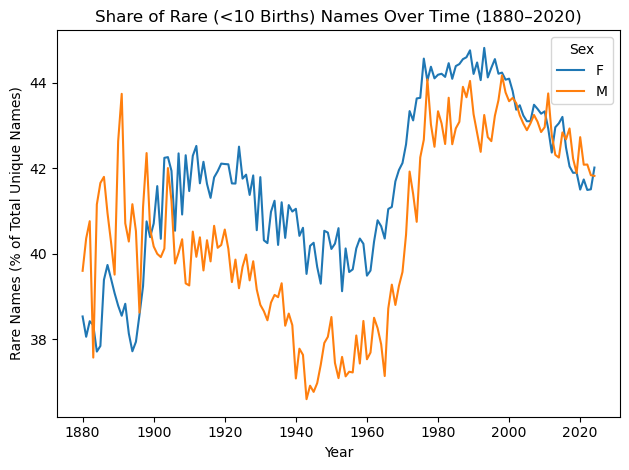

In [4]:
# Question 2: How has the share of rare names changed over time?
# --- Filter for names that occur less than 10 times per year ---
rare = df[df['Count'] < 10].copy()

# --- Count how many rare names each year for each sex ---
rare_counts = rare.groupby(['Year', 'Sex'])['Name'].nunique().reset_index(name='Rare_Names')

# --- Total number of names (for normalization) ---
total_counts = df.groupby(['Year', 'Sex'])['Name'].nunique().reset_index(name='Total_Names')

# --- Merge and calculate the proportion of rare names ---
rare_share = pd.merge(rare_counts, total_counts, on=['Year', 'Sex'])
rare_share['Rare_Share'] = 100 * rare_share['Rare_Names'] / rare_share['Total_Names']

sns.lineplot(data=rare_share, x='Year', y='Rare_Share', hue='Sex')
plt.title("Share of Rare (<10 Births) Names Over Time (1880–2020)")
plt.xlabel("Year")
plt.ylabel("Rare Names (% of Total Unique Names)")
plt.legend(title="Sex")
plt.tight_layout()
plt.show()

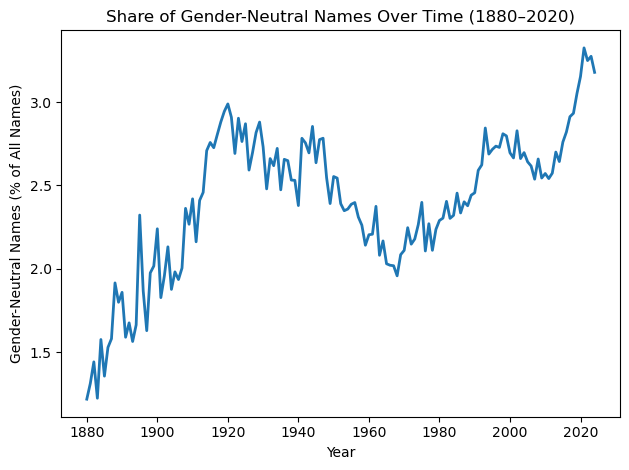

Top 10 Most Common Gender-Neutral Names Overall:



,Name,Total Births (All Years)
5768,Willie,"255,616"
2663,Jordan,"204,732"
2565,Jessie,"197,088"
940,Casey,"168,149"
4695,Riley,"148,742"
278,Angel,"147,268"
2286,Jackie,"141,467"
2628,Johnnie,"112,926"
5378,Taylor,"88,733"
3729,Marion,"87,941"


In [5]:
# Question 3: How have patterns in the popularity of gender-neutral names evolved?
# --- 1. Aggregate counts by year, name, and sex ---
agg = df.groupby(['Year', 'Name', 'Sex'])['Count'].sum().reset_index()

# --- 2. Pivot so each row represents one name per year ---
pivot = agg.pivot_table(index=['Year', 'Name'], columns='Sex', values='Count', fill_value=0).reset_index()

# Ensure both M and F columns exist (fill zeros where missing)
pivot['M'] = pivot.get('M', 0)
pivot['F'] = pivot.get('F', 0)

# --- 3. Compute total births and male ratio ---
pivot['Total'] = pivot['M'] + pivot['F']
pivot = pivot[pivot['Total'] > 0]  # keep only names that appear at least once that year
pivot['Male_Ratio'] = pivot['M'] / pivot['Total']

# --- 4. Define gender-neutral names as those between 30%–70% male ---
pivot['Gender_Neutral'] = pivot['Male_Ratio'].between(0.3, 0.7)

# --- 5. Compute yearly share of gender-neutral names ---
neutral_trend = pivot.groupby('Year')['Gender_Neutral'].mean().reset_index()
neutral_trend['Gender_Neutral'] *= 100  # convert to percentage

# --- 6. Plot trend over time ---
sns.lineplot(data=neutral_trend, x='Year', y='Gender_Neutral', linewidth=2)
plt.title("Share of Gender-Neutral Names Over Time (1880–2020)")
plt.xlabel("Year")
plt.ylabel("Gender-Neutral Names (% of All Names)")
plt.tight_layout()
plt.show()

# --- Top 10 most common gender-neutral names overall ---
neutral_years = pivot[pivot['Gender_Neutral']]

neutral_popular = (
    neutral_years.groupby('Name')['Total']
    .sum()
    .reset_index()
    .sort_values(by='Total', ascending=False)
    .head(10)
)

# --- Clean up formatting ---
neutral_popular.rename(columns={'Name': 'Name', 'Total': 'Total Births (All Years)'}, inplace=True)
neutral_popular['Total Births (All Years)'] = neutral_popular['Total Births (All Years)'].map('{:,.0f}'.format)

print("Top 10 Most Common Gender-Neutral Names Overall:\n")
display(neutral_popular)